In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# fix random seeds for reproductubility
from catalyst.dl import utils

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

# Research 101
The goal of this homework is to give you an experience of coding in pytorch and doing scientific research.

In this homework you are going to do tiny research for image classification problem.
You will
- (re)implement one of the recently developed layers
- create reasonable baseline
- modify your baseline net with your fancy layer to improve speed/accuracy
- analyze the results

## Important notes before you start
- Your results must be entirely reproducible (if we re-run the notebook the output numbers should be exactly the same)
- Some of the proposed layers are already implemented and open-sourced, please try to implement them yourself. At a certain point of correlation you may be penalized for plagiarism (eigther with your peers or with open-source projects)
- Your baseline should not be undertrained or overfitted (penalties apply)
- Your proposed network should be better compared to baseline in some sense
- Please leave your comments when it is appropriate (at the very least in conclusion)

## (re) implement fancy layer
Take a look into these research papers. You should choose **one** of them and implement the proposed layer.
1. [Octave convolution](https://arxiv.org/abs/1904.05049)
2. [Local self-attention](https://arxiv.org/pdf/1906.05909.pdf)
3. [Box convolution](https://papers.nips.cc/paper/7859-deep-neural-networks-with-box-convolutions)
4. You may choose another paper interesting to you, in that case please consult with us before start working
5. You may propose your own layer (we highly recommend to think about this at least for some time, but you should not be too concentrated). In case of success, this last choice will be awarded with additional points, but again we **higly recommend** to consult with us before start your work.

Fun exercise: Try to detect a bachelor thesis of your peers in the above list

In [3]:
# TODO: implement your layer as nn.Module

## Set up your experiment
You should choose:
- the dataset (take a look into torchvision.datasets). ensure you are solving classification problem. the dataset should not be MNIST (at least take FashionMnist)
- criterion, optimizer, learning rate (everything of this should be fixed for different model comparation, but choose wisely, e.g. training classification with l1 loss is definetly a bad idea)
- target metric (accuracy or f-score)
- augmentations (you may ignore them)

### Dataset

Will be used next dataset - [best artworks of all time](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)

In [4]:
from dataset import prepare_data, create_reader
from dataset import show_examples
from dataset import get_transforms
from dataset import get_loaders

In [5]:
ROOT = '/notebook/datasets/cifar-10'
batch_size = 25

In [6]:
train_data, valid_data, class_names = prepare_data(ROOT, SEED)
open_fn = create_reader(ROOT, len(class_names))

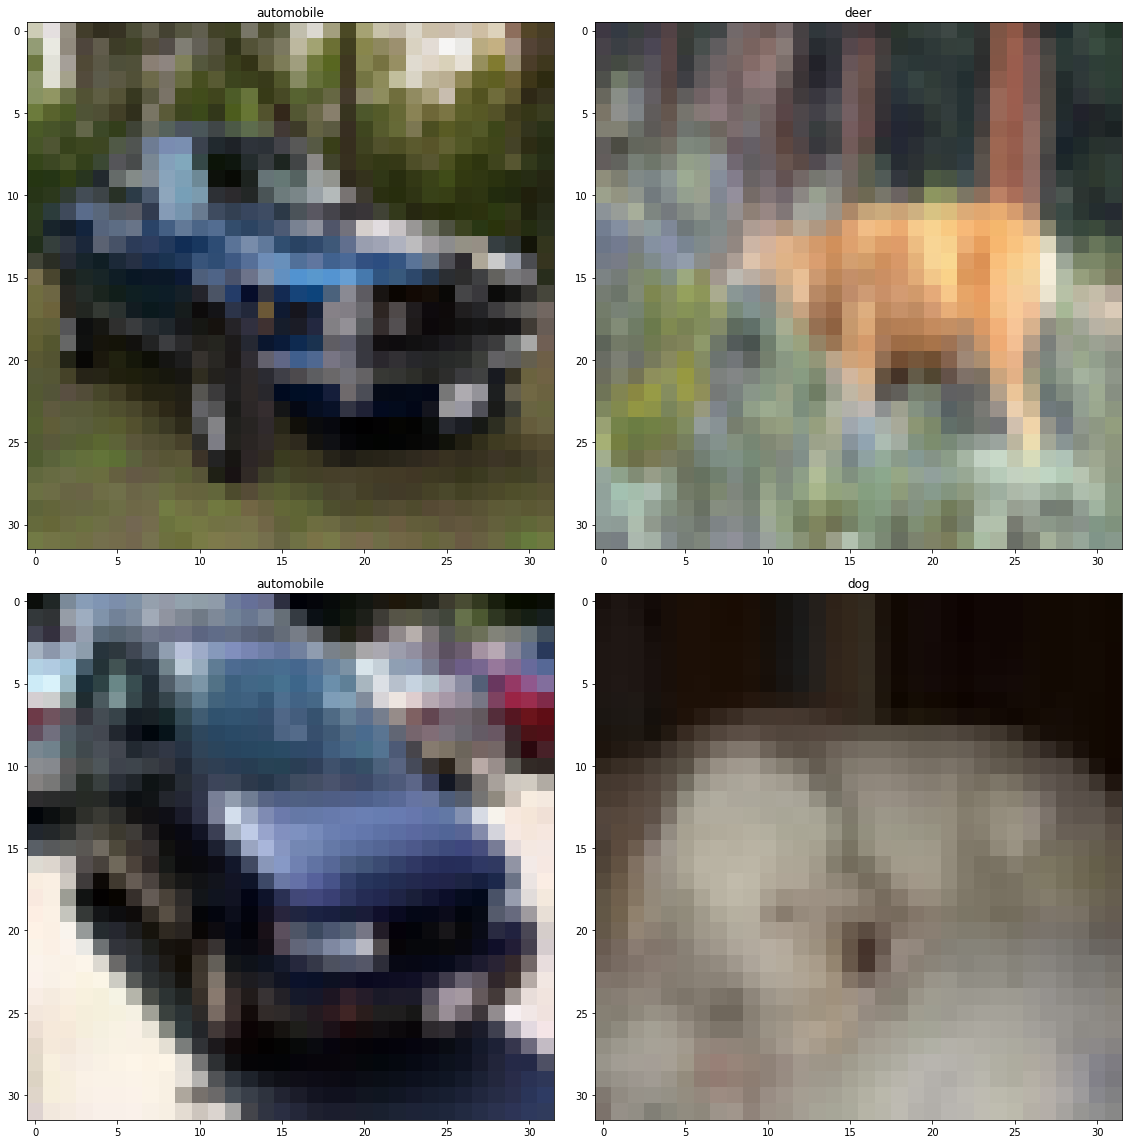

In [7]:
# # look at some painting
show_examples(train_data)

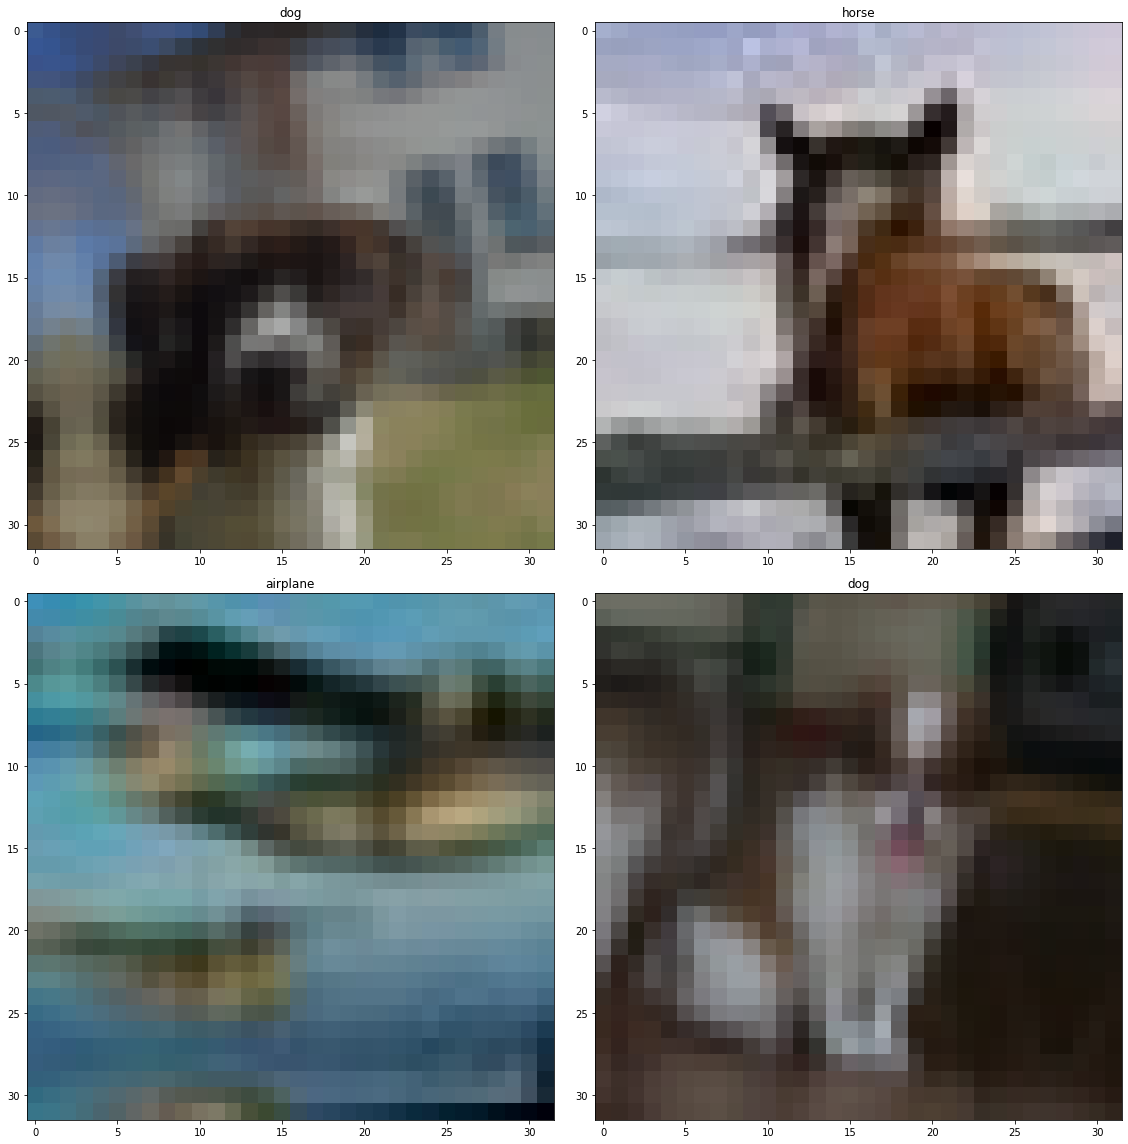

In [8]:
# get some augmentations

train_data_transforms, valid_data_transforms, show_transforms = get_transforms()
show_examples(train_data, show_transforms)

In [9]:
# create loaders to run experiments

loaders = get_loaders(
    train_data,
    valid_data,
    open_fn,
    train_transforms_fn=train_data_transforms,
    valid_transforms_fn=valid_data_transforms,
    batch_size=batch_size
)

## Create baseline
Choose baseline network of reasonable size & training time. You may take some ResNet or DenseNet for example.

Train baseline network. **Ensure you have not undertrain/overfit your baseline** (You will be penalized if it will be detected)

---

I won't use ImageNet pretrained weights, to make experiments fair

In [26]:
import numpy as np

In [10]:
num_classes = len(class_names)

In [12]:
from models import create_training_configs
from callbacks import get_callbacks

from catalyst.dl.utils import get_device
from catalyst.dl.runner import SupervisedRunner

In [22]:
from models import create_resnet26_vanilla

In [ ]:
model_vanilla = create_resnet26_vanilla(num_classes)

optimizer, criterion, scheduler = create_training_configs(model_vanilla)

In [52]:
num_epochs = 10
logdir = "/notebook/model_logs/resnet26_vanilla"
device = get_device()
print(f'Device: {device}')

runner = SupervisedRunner(device=device)

Device: cuda


In [ ]:
callbacks = get_callbacks(class_names)

In [ ]:
runner.train(
    model=model_vanilla,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=callbacks,
    logdir=logdir,
    num_epochs=num_epochs,
    # save our best checkpoint by AUC metric
    main_metric="auc/_mean",
    # AUC needs to be maximized.
    minimize_metric=False,
    # prints train logs
    verbose=True
)

In [53]:
predictions_vanilla = runner.predict_loader(
    model_vanilla, loaders["valid"],
    resume=f"{logdir}/checkpoints/best.pth", verbose=True
)

=> loading checkpoint /notebook/model_logs/resnet26_vanilla/checkpoints/best.pth
loaded checkpoint /notebook/model_logs/resnet26_vanilla/checkpoints/best.pth (epoch 10)
1/1 * Epoch (infer): 100% 400/400 [00:04<00:00, 95.38it/s] 
Top best models:



In [54]:
true = []
for d in loaders['valid']:
    true.extend(d['targets'])

valid_acc = np.mean(np.array(true) == predictions_vanilla.argmax(1))
print(f'Validation accuracy: {valid_acc}')

Validation accuracy: 0.8822


## Improve baseline network with your layer
Modify baseline architecture (your modification should be comparable or better to baseline in terms of metrics, speed, number of parameters), train your proposed network and compare it to baseline.

Compare the results with baseline (and maybe different versions of your proposed network) in terms of:
- quality metrics
- inference speed
- number of parameters
- (optional) FLOPS
- (optional) training time until convergence

In [53]:
from models import create_resnet26_attn

In [13]:
model = create_resnet26_attn(num_classes)

optimizer, criterion, scheduler = create_training_configs(model)

In [14]:
num_epochs = 10
logdir = "/notebook/model_logs/resnet26_attn_no_stem"
device = get_device()
print(f'Device: {device}')

runner = SupervisedRunner(device=device)

Device: cuda


In [15]:
callbacks = get_callbacks(class_names)

In [ ]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=callbacks,
    logdir=logdir,
    num_epochs=num_epochs,
    # save our best checkpoint by AUC metric
    main_metric="auc/_mean",
    # AUC needs to be maximized.
    minimize_metric=False,
    # prints train logs
    verbose=True
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/10 * Epoch (train): 100% 1600/1600 [10:06<00:00,  2.64it/s, accuracy01=52.000, accuracy03=80.000, accuracy05=92.000, f1_score=0.350, loss=1.458]  
1/10 * Epoch (valid): 100% 400/400 [00:23<00:00, 17.31it/s, accuracy01=60.000, accuracy03=84.000, accuracy05=88.000, f1_score=0.441, loss=1.238]  
[2019-12-08 12:12:12,834] 
1/10 * Epoch 1 (train): _base/lr=0.0003 | _base/momentum=0.9000 | _timers/_fps=2257.3041 | _timers/batch_time=0.0114 | _timers/data_time=0.0008 | _timers/model_time=0.0106 | accuracy01=37.9675 | accuracy03=72.2100 | accuracy05=87.0675 | auc/_mean=0.8058 | auc/class_airplane=0.8292 | auc/class_automobile=0.8760 | auc/class_bird=0.6965 | auc/class_cat=0.7556 | auc/class_deer=0.7613 | auc/class_dog=0.7987 | auc/class_frog=0.8447 | auc/class_horse=0.7870 | auc/class_ship=0.8746 | auc/class_truck=0.8343 | f1_score=0.2688 | loss=1.7134
1/10 * Epoch 1 (valid): _base/lr=0.0003 | _base/momentum=0.9000 | _timers/_fps=2877.9557 | _timers/batch_time=0.0092 | _timers/data_time=0.00

In [47]:
predictions = runner.predict_loader(
    model, loaders["valid"],
    resume=f"{logdir}/checkpoints/best.pth", verbose=True
)

=> loading checkpoint /notebook/model_logs/resnet26_attn_no_stem/checkpoints/best.pth
loaded checkpoint /notebook/model_logs/resnet26_attn_no_stem/checkpoints/best.pth (epoch 10)
1/1 * Epoch (infer): 100% 400/400 [00:21<00:00, 18.22it/s]
Top best models:



In [48]:
true = []
for d in loaders['valid']:
    true.extend(d['targets'])

valid_acc = np.mean(np.array(true) == predictions.argmax(1))
print(f'Validation accuracy: {valid_acc}')

Validation accuracy: 0.8395


## Results
Visualize your results somehow, as a simplest case you may provide the table with comparation of baseline (and maybe different versions of your proposed network)

In [34]:
from sklearn.metrics import confusion_matrix

In [39]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

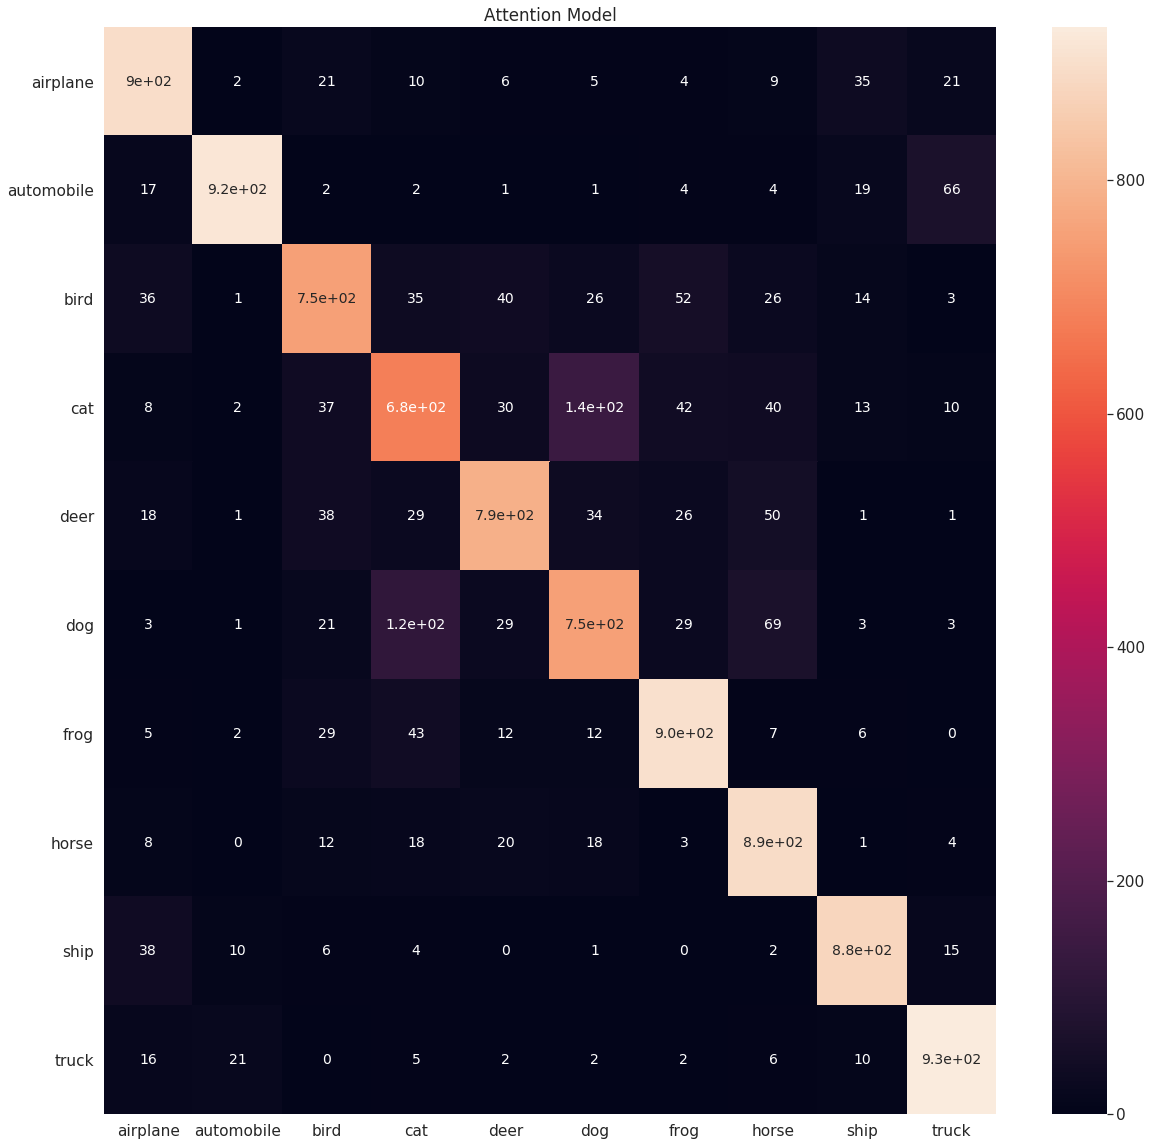

In [92]:
df_cm = pd.DataFrame(confusion_matrix(true, predictions.argmax(1)), index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (20,20))
sn.set(font_scale=1.4)#for label size
ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 14, 'va':'center'})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Attention Model')
plt.yticks(rotation=0)
plt.show()

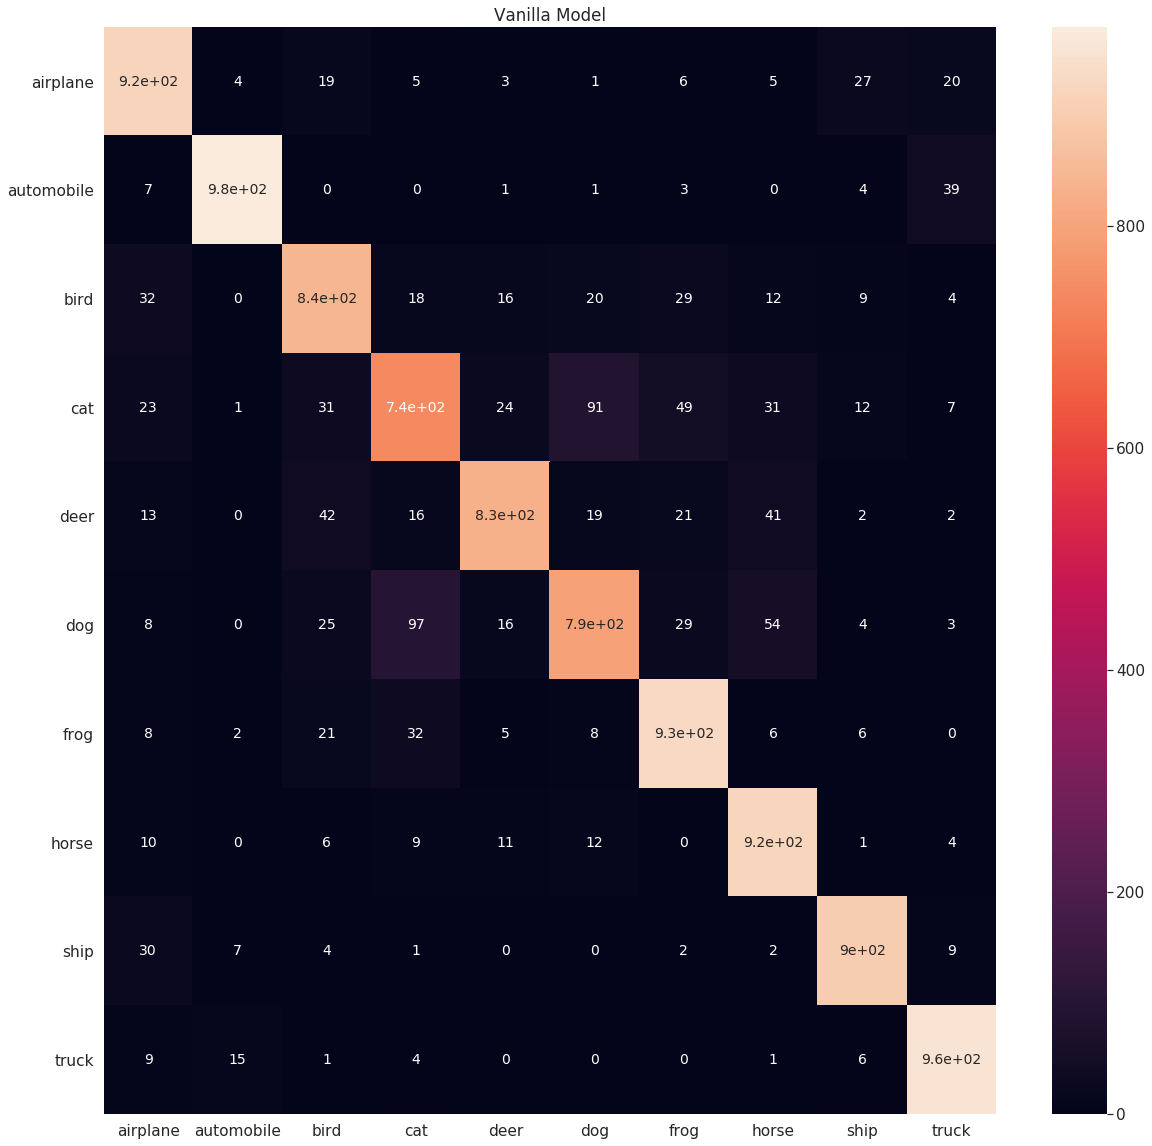

In [93]:
df_cm = pd.DataFrame(confusion_matrix(true, predictions_vanilla.argmax(1)), index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (20,20))
sn.set(font_scale=1.4)#for label size
ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 14, 'va':'center'})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Vanilla Model')
plt.yticks(rotation=0)
plt.show()

Count ops using [thop](https://pypi.org/project/thop/) library

In [98]:
from thop import profile, clever_format
from torch import randn

In [99]:
inp = randn(1, 3, 32, 32)

Vanilla model

In [111]:
flops, params = profile(model_vanilla, inputs=(inp.to(device), ))

Register FLOP counter for module Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Register FLOP counter for module BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Register FLOP counter for module ReLU()
Register FLOP counter for module Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
Register FLOP counter for module BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Register FLOP counter for module ReLU()
Register FLOP counter for module Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Register FLOP counter for module BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Register FLOP counter for module ReLU()
Register FLOP counter for module Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Register FLOP counter for module BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Register FLOP counter for m

In [113]:
flops, params = clever_format([flops, params], "%.3f")

In [114]:
flops, params

('1.230G', '11.662M')

In [107]:
flops, params = profile(model, inputs=(inp.to(device), ))

Register FLOP counter for module Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Register FLOP counter for module BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Register FLOP counter for module ReLU()
Register FLOP counter for module Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
Register FLOP counter for module BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Register FLOP counter for module ReLU()
Register FLOP counter for module Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), groups=8, bias=False)
Register FLOP counter for module Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), groups=8, bias=False)
Register FLOP counter for module Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), groups=8, bias=False)
Register FLOP counter for module BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Register FLOP counter for module ReLU()
Register FLOP counter

In [109]:
flops, params = clever_format([flops, params], "%.3f")

In [110]:
flops, params

('1.273G', '6.820M')

## Conclusions
Summarize the results briefly. What are the main benefits of your approach?

К сожалению, добиться улучшения качества resnet с помощью замены `conv3x3` на `self-attention` у меня не получилось

В первую очередь, это связано с тем, что `self-attention` слой, реализованный на `pyton` вычисляется намного дольше, чем `conv3x3` и занимает намного больше памяти, при вычислении. (у меня не получилось запихнуть в `self-attention` модель картинку `(3, 224, 244)` из-за ООМ)

Мне кажется, что данный слой надо реализовать на `C++`, чтобы сократить время, которое тратится на передачу управления, и количество потребляемой памяти